In [2]:
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.filters import StaticAssets, Q1500US, Q500US
from quantopian.pipeline.data import factset, USEquityPricing
from quantopian.pipeline.classifiers.fundamentals import Sector
from quantopian.pipeline.factors import Returns, SimpleMovingAverage, CustomFactor, RSI

from alphalens.performance import mean_information_coefficient
from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.tears import create_information_tear_sheet, create_returns_tear_sheet

from quantopian.pipeline.data.user_5e418228b06032004658abd6 import wikipedia_pageviews

In [4]:
def make_pipeline():
    
    base_universe = Q500US()


    price_moving_average_20 = SimpleMovingAverage(
        inputs=[USEquityPricing.close], 
        window_length=20,
        mask = base_universe
    )
    
    current_price = USEquityPricing.close.latest
    
    
    twenty_day_momentum = (current_price - price_moving_average_20)/price_moving_average_20
    
#     '''             
    wiki_views = wikipedia_pageviews.views.latest
    wiki_views_sma10 = SimpleMovingAverage(
        inputs = [wikipedia_pageviews.views],
        window_length=10,
        mask = base_universe
    )
    
    last_open = USEquityPricing.open.latest
    one_day_momentum = (current_price - last_open)/last_open
    
    views_spike_filter = (wiki_views - wiki_views_sma10)/ wiki_views_sma10 >.2
#     '''
    
    factor1 = twenty_day_momentum  + 5*one_day_momentum
#     factor1 = twenty_day_momentum  
    sector = Sector()
    
    return Pipeline(
        columns = {'factor1': factor1 , 'sector': sector },
        screen = views_spike_filter
#         screen = base_universe
    )

factor_data = run_pipeline(make_pipeline(), '2015-7-2', '2016-7-1')


Dropped 0.7% entries from factor data: 0.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


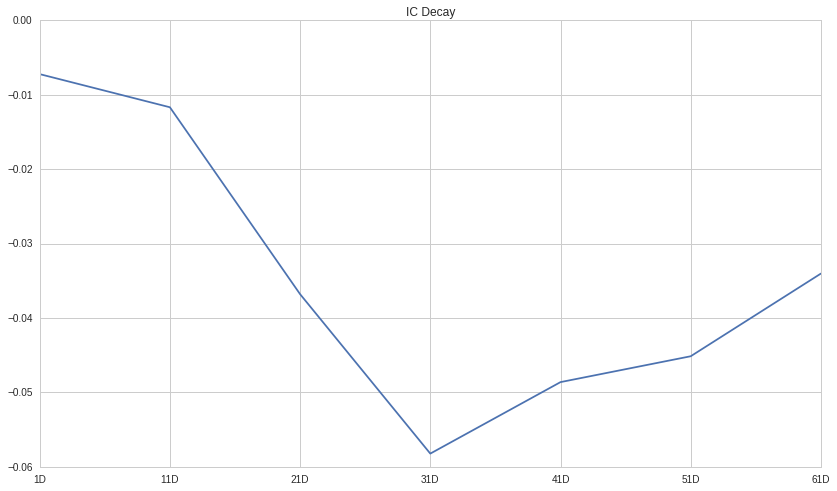

In [5]:
pricing_data = get_pricing(factor_data.index.levels[1], '2015-7-2', '2017-7-1', fields='open_price')

longest_look_forward_period = 63 # week = 5, month = 21, quarter = 63, year = 252
range_step = 10

merged_data = get_clean_factor_and_forward_returns(
    factor = factor_data['factor1'],
    prices = pricing_data,
    periods = range(1, longest_look_forward_period, range_step)
)



mean_information_coefficient(merged_data).plot(title="IC Decay")

## Create Group Neutral Tear Sheets

Dropped 5.1% entries from factor data: 0.3% in forward returns computation and 4.8% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Information Analysis


,1D,5D,10D,30D
IC Mean,0.002,0.008,0.020,0.005
IC Std.,0.346,0.339,0.338,0.331
Risk-Adjusted IC,0.007,0.025,0.059,0.015
t-stat(IC),0.107,0.385,0.913,0.241
p-value(IC),0.915,0.700,0.362,0.810
IC Skew,-0.408,-0.554,-0.127,-0.260
IC Kurtosis,2.619,2.560,2.696,2.975


/venvs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


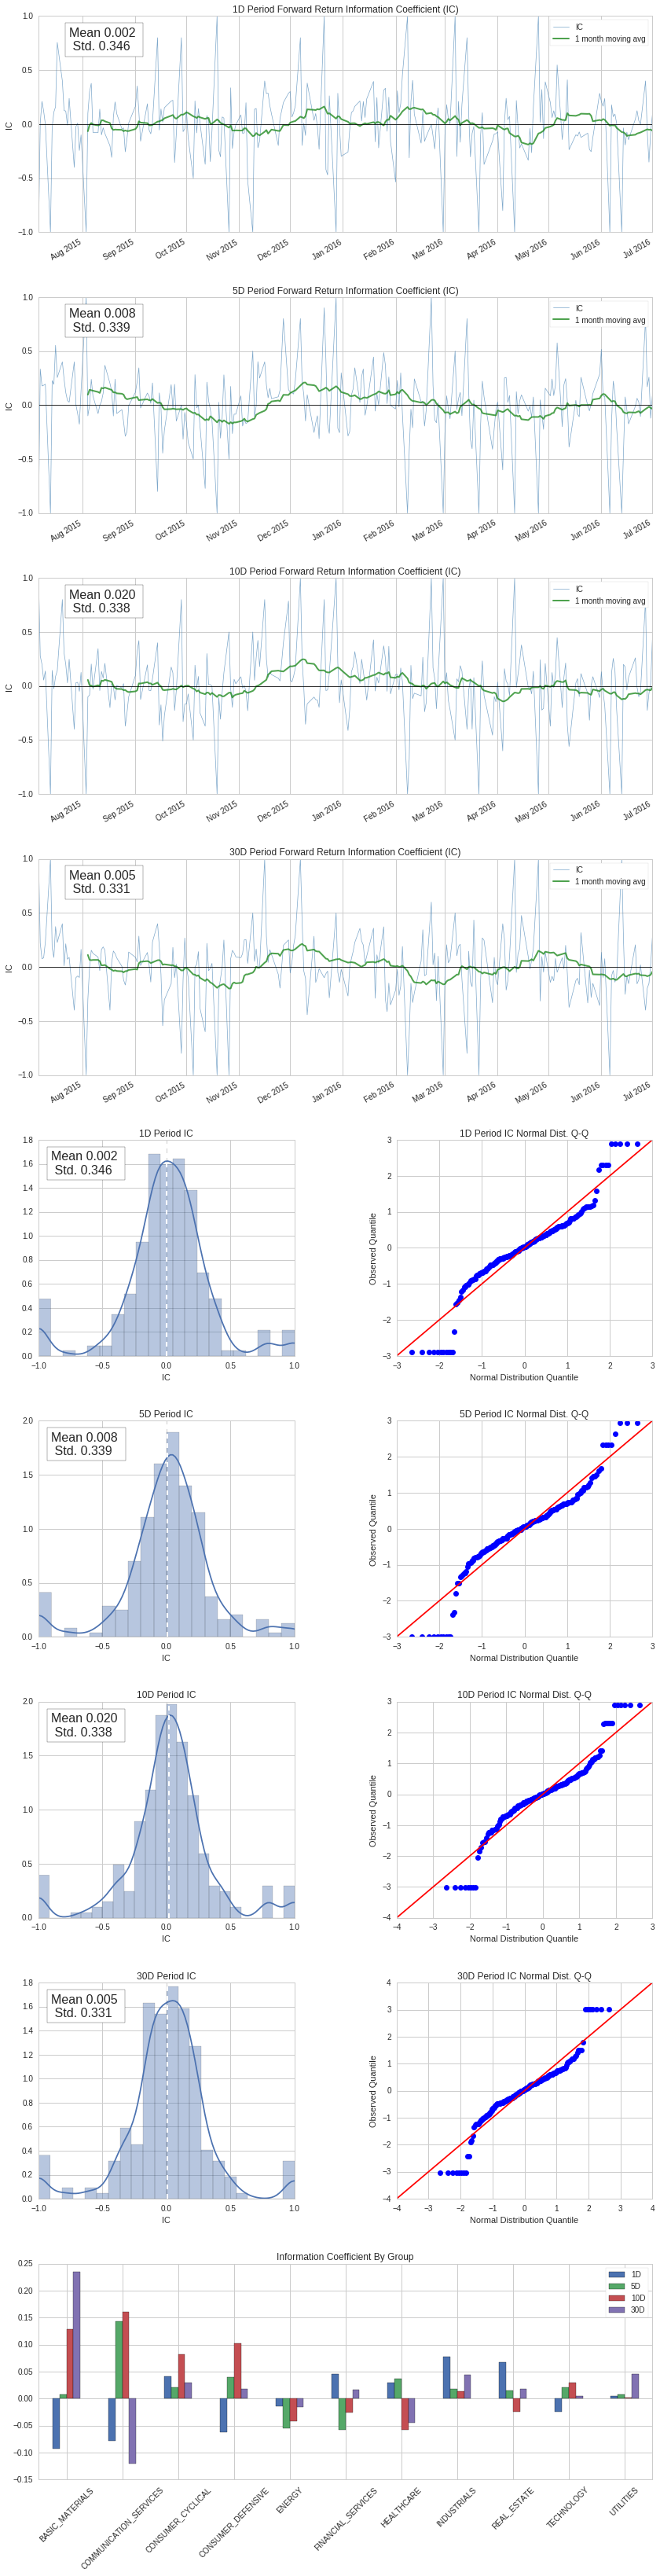

Returns Analysis


,1D,5D,10D,30D
Ann. alpha,0.159,-0.004,0.001,-0.018
beta,-0.116,-0.109,-0.123,-0.132
Mean Period Wise Return Top Quantile (bps),2.529,-2.541,-1.191,-1.496
Mean Period Wise Return Bottom Quantile (bps),-5.277,-2.338,-1.534,-0.283
Mean Period Wise Spread (bps),7.806,-0.157,0.369,-1.160


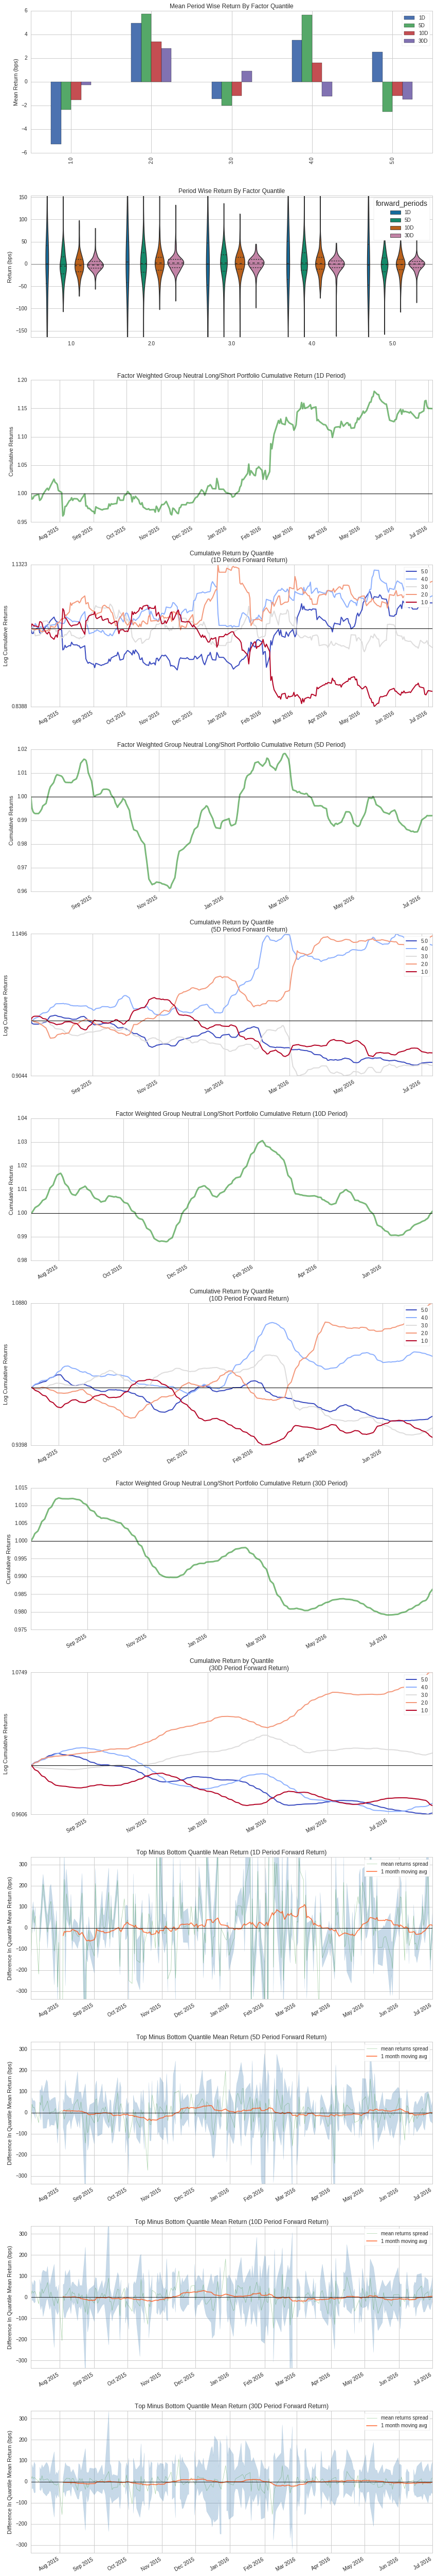

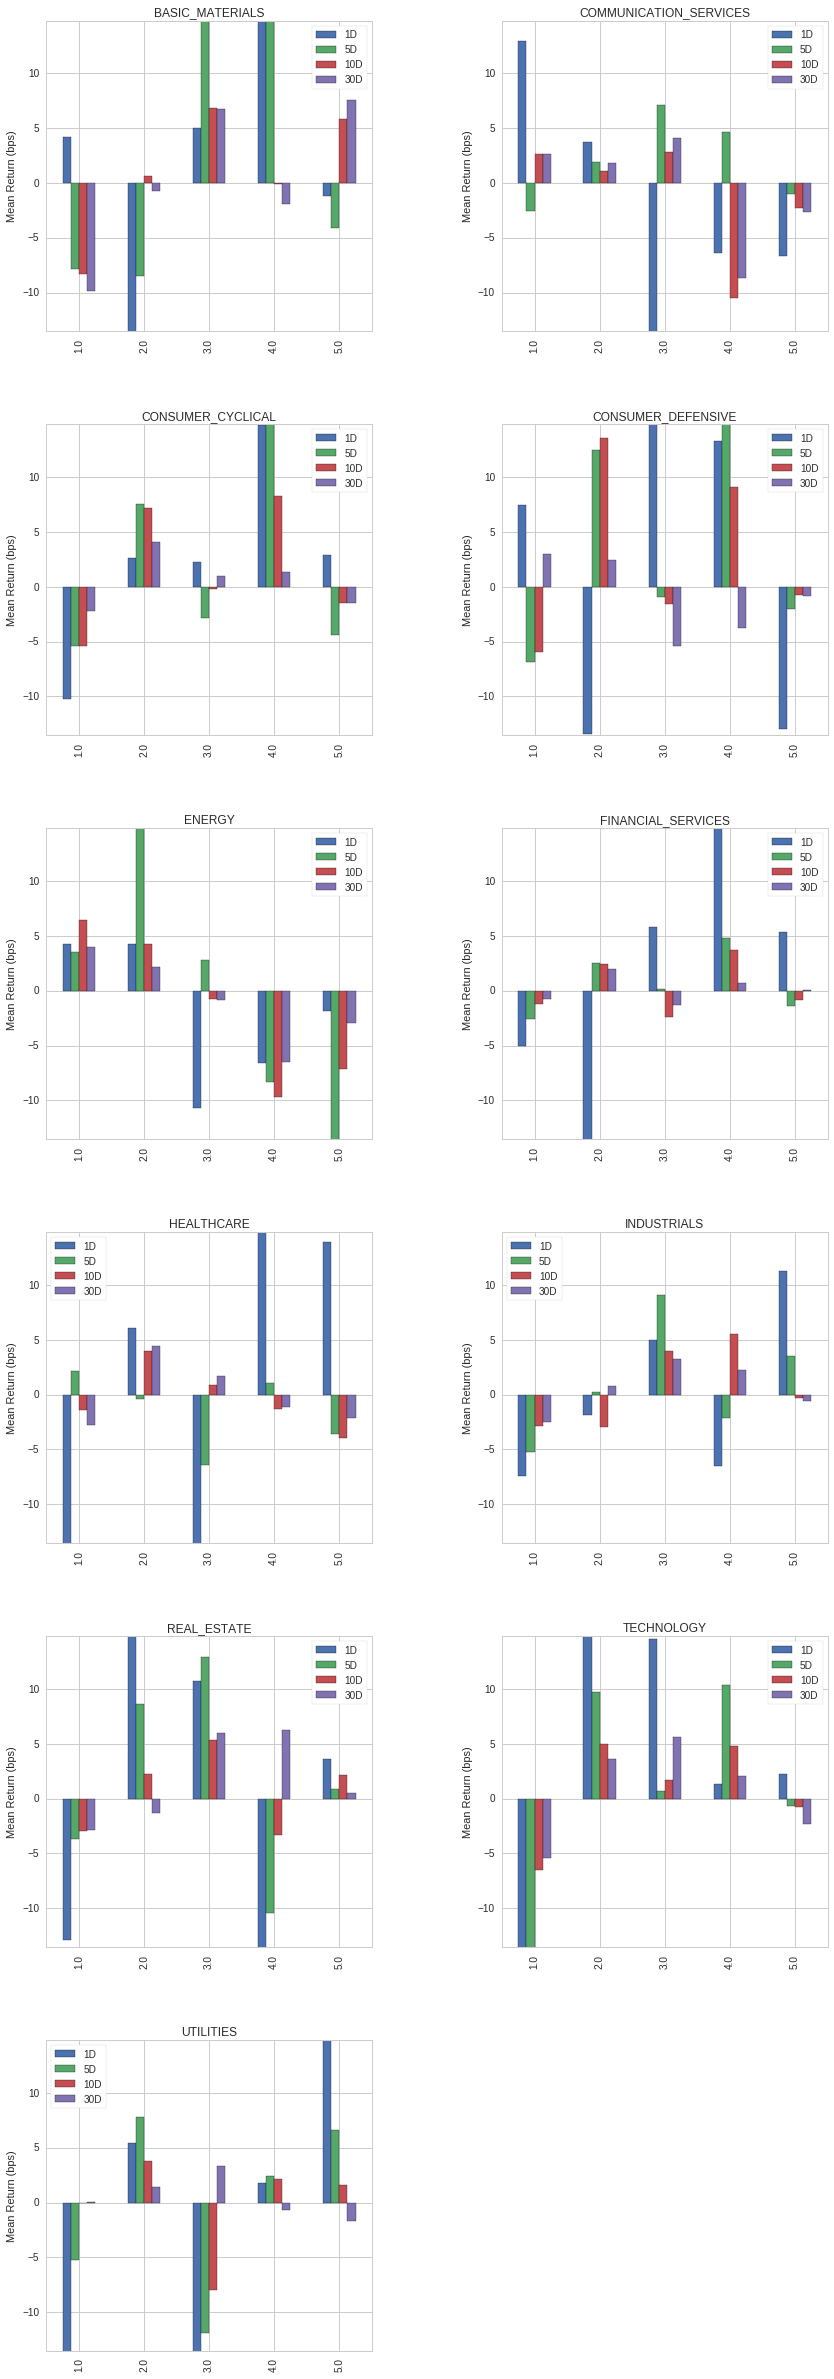

In [6]:
sector_labels, sector_labels[-1] = dict(Sector.SECTOR_NAMES), "Unknown"

merged_data = get_clean_factor_and_forward_returns(
    factor = factor_data['factor1'],
    prices = pricing_data,
    groupby = factor_data['sector'],
    groupby_labels = sector_labels,
    binning_by_group = True,
    periods = (1,5,10,30)
)

create_information_tear_sheet(merged_data, by_group=True, group_neutral=True)
create_returns_tear_sheet(merged_data, by_group=True, group_neutral=True)